# 成功读取BTCUSDT:binance的数据，绘出30Min和1H的gap图

'start_date':20180601000000

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [17]:
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': \
         'BTCUSDT:binance,ETHUSDT:binance,EOSUSDT:binance',
         'freq': '30Min,1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props) #读取数据
print(time()-start)

20.06597328186035


In [18]:
#调用模块
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv30M = HFDataView()
dv1H = HFDataView()

#初始化
dv30M.create_init_dv(Time_dict['30Min'].dropna().set_index(["trade_date","symbol"]))
dv1H.create_init_dv(Time_dict['1H'].dropna().set_index(["trade_date","symbol"]))

Gap30 = dv30M.add_formula('gap', 'close-Delay(open, 1)',add_data=True)
Gap1H = dv1H.add_formula('gap', 'close-Delay(open, 1)',add_data=True)

Initialize dataview success.
Initialize dataview success.


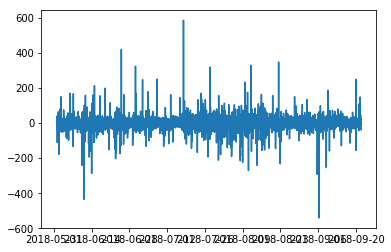

In [20]:
import matplotlib.pyplot as plt


plt.plot(dv30M.get_ts('gap', date_type='datetime')['BTCUSDT:binance'])
plt.show()

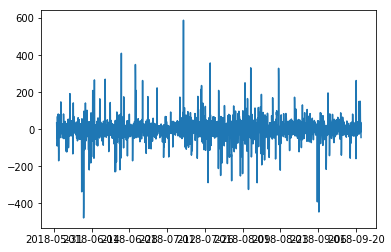

In [21]:
plt.plot(dv1H.get_ts('gap', date_type='datetime')['BTCUSDT:binance'])
plt.show()

# 2、调用alpha101research中的alpha10进行绘图，定义事件，打印绩效

要求：

1、绘出alpha10_dv30M_ma5_ma20、alpha10_dv1H_ma5_ma20的图。

2、定义alpha10的金叉死叉事件，周期为20和55，并打印出long_short的绩效

In [25]:
for dvAdd in [dv30M, dv1H]:
    dvAdd.add_formula('alpha10_C','If(Ts_Min(Delta(close,1),4)>0,Delta(close,1),If((Ts_Max(Delta(close,1),4)<0),Delta(close,1),(-1*Delta(close,1))))',add_data=True)

D:\Anaconda3\lib\site-packages\jaqs\data\py_expression_eval.py:477: RuntimeWarning: invalid value encountered in greater
  res = arr > brr
D:\Anaconda3\lib\site-packages\jaqs\data\py_expression_eval.py:486: RuntimeWarning: invalid value encountered in less
  res = arr < brr


In [57]:
import matplotlib.pyplot as plt

def Plot_Mean(dv, alpha, chart_name='dv_alpha_ma', ShortPeriod=5, LongPeriod=20, n=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:])
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax1.plot(alpha.iloc[n:], alpha=0.1)
    ax1.plot(pd.Series(alpha.rolling(ShortPeriod).mean(), index=alpha.index).iloc[n:])
    ax1.plot(pd.Series(alpha.rolling(LongPeriod).mean(), index=alpha.index).iloc[n:])


#     plt.savefig(chart_name)
    plt.show()

In [51]:
dv_dict = {'alpha10_dv30M':dv30M, 'alpha10_dv1H':dv1H}
alpha10_dict = {n: dv.get_ts('alpha1_C', date_type='datetime') for n, dv in dv_dict.items()}

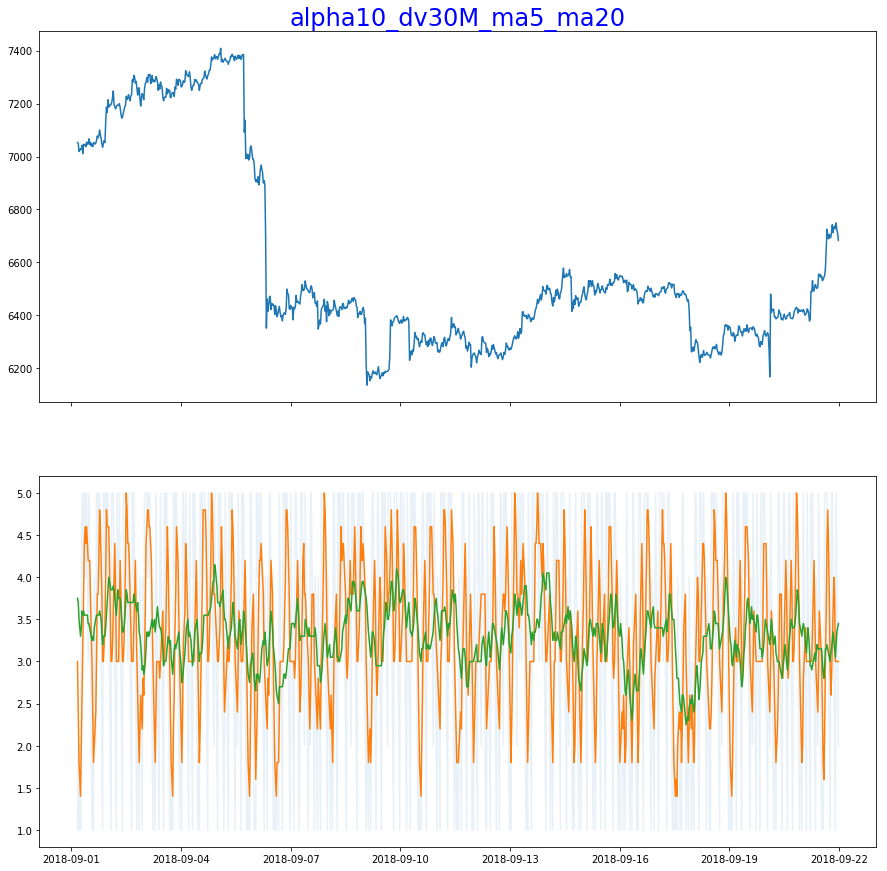

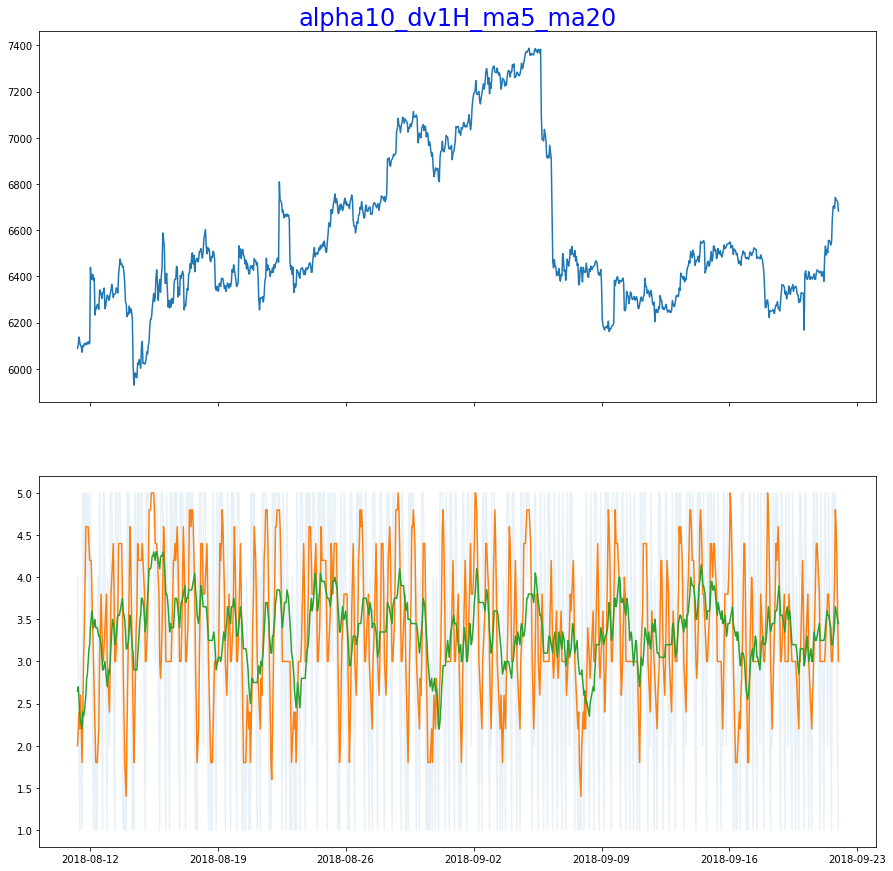

In [58]:
import pandas as pd
#alpha1_dv15M是15分钟线，1H是1小时线，ma30和ma60代表对信号进行均线处理和观察是否与价格存在涨跌关系
for name, alpha in alpha10_dict.items():
    Plot_Mean(globals()[name.split('_')[1]], alpha.iloc[:,0], chart_name=name+'_ma5_ma20',ShortPeriod=5, LongPeriod=20, n=-1000)#橘色短线 绿色长线

In [69]:
# 进场信号
long = dv1H.add_formula("longAlpha10","If((Ts_Mean(alpha10_C,20)>Ts_Mean(alpha10_C,55)) && (Delay(Ts_Mean(alpha10_C,20),1)<=Delay(Ts_Mean(alpha10_C,55),1)),2,0)", add_data=True)
short = dv1H.add_formula("shortAlpha10","If((Ts_Mean(alpha10_C,20)<Ts_Mean(alpha10_C,55)) && (Delay(Ts_Mean(alpha10_C,20),1)>=Delay(Ts_Mean(alpha10_C,55),1)),-2,0)", add_data=True)

# 出场信号
close_long = dv1H.add_formula("closeLongAlpha10","If(shortAlpha10==-2,1,0)", add_data=True)
close_short = dv1H.add_formula("closeShortAlpha10","If(longAlpha10==2,-1,0)", add_data=True)

Field [longAlpha10] is overwritten.
Field [shortAlpha10] is overwritten.
Field [closeLongAlpha10] is overwritten.
Field [closeShortAlpha10] is overwritten.


D:\Anaconda3\lib\site-packages\jaqs\data\py_expression_eval.py:477: RuntimeWarning: invalid value encountered in greater
  res = arr > brr
D:\Anaconda3\lib\site-packages\jaqs\data\py_expression_eval.py:504: RuntimeWarning: invalid value encountered in less_equal
  res = arr <= brr
D:\Anaconda3\lib\site-packages\jaqs\data\py_expression_eval.py:486: RuntimeWarning: invalid value encountered in less
  res = arr < brr
D:\Anaconda3\lib\site-packages\jaqs\data\py_expression_eval.py:495: RuntimeWarning: invalid value encountered in greater_equal
  res = arr >= brr


In [71]:
dv1H.get_ts('longAlpha10').stack()[dv1H.get_ts('longAlpha10').stack()==2].tail()

trade_date      symbol         
20180920220000  ETHUSDT:binance    2.0
20180920230000  BTCUSDT:binance    2.0
                EOSUSDT:binance    2.0
20180921100000  ETHUSDT:binance    2.0
20180921140000  ETHUSDT:binance    2.0
dtype: float64

In [116]:
from jaqs_fxdayu.research import TimingDigger

tdMaStatistic = TimingDigger(output_folder=".", output_format='pdf',signal_name='MaStatistic')

def TimingSignal(td, dv, long='long', short='short',closeLong='closeLong', closeShort='closeShort'\
                 , mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

tdAlpha10 = TimingDigger(output_folder=".", output_format='pdf',signal_name='Alpha010')

TimingSignal(tdAlpha10, dv1H,'longAlpha10','shortAlpha10','closeLongAlpha10','closeShortAlpha10', 100, 0.05, 0.3)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 6%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 6%


In [115]:
tdAlpha10.create_event_report(sig_type="long_short")#同时计算多空头信号的绩效

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat               17.781  -16.570    0.531
p-value               0.000    0.000    0.595
mean                  0.015   -0.016    0.000
std                   0.019    0.021    0.025
info_ratio            0.799   -0.792    0.017
skewness              2.235   -1.599   -0.011
kurtosis              5.530    1.479    3.238
pct5                  0.001   -0.061   -0.054
pct25                 0.003   -0.019   -0.006
pct50                 0.008   -0.007    0.001
pct75                 0.018   -0.003    0.009
pct95                 0.059   -0.001    0.044
occurance           496.000  439.000  935.000
win_ratio               NaN      NaN    0.530
win_mean/loss_mean      NaN      NaN    0.936


# 3、打印出Morningstar事件的时间点，绘出Morningstar与成交量的图

数据类型要求：'symbol': 'BTCUSDT:binance',

'freq': '1H','start_date':20180601000000

In [6]:
import warnings
warnings.filterwarnings('ignore')
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': \
         'BTCUSDT:binance',
         'freq': '1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props) #读取数据
print(time()-start)

5.54174017906189


In [8]:
#调用模块
data1H = Time_dict.set_index('datetime')
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv1H = HFDataView()

#初始化
dv1H.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

Initialize dataview success.


In [9]:
import matplotlib.pyplot as plt
import mpl_finance as mpf

def draw_candle(candle, scatterX, scatterY):
    fig, (ax, ax1) = plt.subplots(2,1,sharex=True, figsize=(18,10))
    ax.grid(True)
    mpf.candlestick_ohlc(ax, candle, width=0.3, colorup='r', colordown='g',alpha=1.0)
    ax.scatter(scatterX, scatterY, color='b', s=100, marker='^')
    ax.xaxis_date ()
    ax1.bar(data1H.index, data1H.volume)
    plt.show()

In [10]:
morningstar = dv1H.add_formula('morningstar', "If((Ta('CDLMORNINGSTAR', 0, open, high, low, close, volume)==100),100,0)", add_data=True)
morningstarVolume = dv1H.get_ts('morningstar', date_type='datetime')
morningstarVolume[morningstarVolume['BTCUSDT:binance']==100]

symbol,BTCUSDT:binance
trade_date,
2018-06-15 22:00:00,100.0
2018-07-12 11:00:00,100.0
2018-07-19 06:00:00,100.0
2018-08-09 17:00:00,100.0
2018-08-31 04:00:00,100.0
2018-09-11 02:00:00,100.0
2018-09-18 01:00:00,100.0
2018-09-19 09:00:00,100.0


In [11]:
from matplotlib.pylab import date2num

data1H['candleTime'] = list(map(date2num, data1H.index))
candle = data1H.reindex_axis(["candleTime", "open", "high", "low", "close"], 1).values

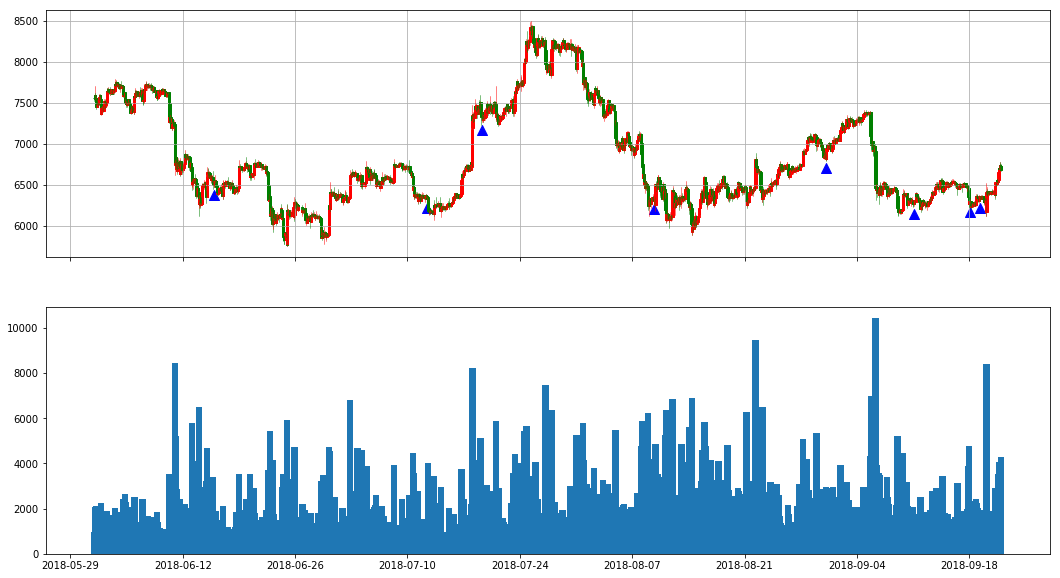

In [12]:
morningstarVolumeX = morningstarVolume[morningstarVolume['BTCUSDT:binance']==100].index
morningstarVolumeY = data1H.loc[morningstarVolumeX].low-100

draw_candle(candle, morningstarVolumeX, morningstarVolumeY)